In [1]:
from classy_sz import Class


import sys
sys.path.insert(1,'../code/')

import estim 


import importlib
importlib.reload(estim)

import config as conf
import numpy as np
from matplotlib import pyplot as plt

#Initialize the estimator class. To do so, you have to provide the l_max for your precomputed Cl data (here 6144)
#and you also need the configuration module used when calculating the Cls


import healpy as hp

import pickle
import loginterp


## some setup

In [59]:
'''
you choose the number of velocity bins you want here:
NBIN corresponds to ''pi-bins'' in ReCCO; the number of 
components in redshift space you assign to your Haar-expansion ofthe velocity.

nbin_tracer refers to the number of bins you have in your tracer
for something 1-dimensional like the CIB nbin_tracer is 1

For something like a photometric galaxy survey you can have higher nbin_tracer although
note we have not tested the code for anything except nbin_tracer =1 and nbin_tracer = NBIN
'''

NBIN = 8              
conf.N_bins = NBIN

nbin_tracer = 1

assert (nbin_tracer == NBIN) or (nbin_tracer ==1)


In [67]:
c_mps  =  299792458
c_kmps = c_mps/1000

In [70]:
importlib.reload(estim)

<module 'estim' from '/mnt/home/fmccarthy/ksz/final_ReCCO/ReCCO/notebooks/../code/estim.py'>

### load websky maps:

In [72]:
nside = 4096
npix = hp.nside2npix(nside)
#here we load the websky kSZ map and primary CMB, ie our simulated data

websky_maps_folder = '/mnt/ceph/users/fmccarthy/kSZ/Websky_sims/'  #wherever you have saved it goes here

kszmap = hp.fitsfunc.read_map(websky_maps_folder + 'ksz.fits')/(1e6*2.7)   # ksz map in microK

CMB_alm = hp.fitsfunc.read_alm(websky_maps_folder+'lensed_alm.fits')/(1e6*2.7) # CMB alm in microK

CMBmap = hp.alm2map(CMB_alm,nside=nside)

CIBmap = hp.fitsfunc.read_map(websky_maps_folder + 'cib_nu0545.fits')*1e6   #    CIB in Jy/sr

def remove_point_sources(CIBmap,fluxcut,nside):   #fluxcut in milliJy
    resolution_in_steradians=hp.nside2resol(nside, arcmin=False)**2

    CIBmap_removepoints = CIBmap.copy()
        
    npoints = len(CIBmap_removepoints[CIBmap_removepoints>fluxcut/1000/resolution_in_steradians])
    npix = len(CIBmap_removepoints)
    
    print("removing",npoints,"points out of",npix)
    
    CIBmap_removepoints[CIBmap_removepoints>fluxcut/1000/resolution_in_steradians]=np.mean(CIBmap_removepoints[CIBmap_removepoints>fluxcut/1000/resolution_in_steradians])   
    return CIBmap_removepoints.copy()

CIBmap_removepoints = remove_point_sources(CIBmap,400,nside)  #remove the point sources to reduce the shot noise on the CIB map


removing 11036 points out of 201326592


#### take measured C_ell of maps

We need theoretical power spectra to go into the estimator weights.

In principle these should come from a model. If they are incorrect there will be biases on the reconstruction. To avoid these, for testing purposes we use the measured power spectra (for now).

In [73]:
CMB_cl = hp.alm2cl(CMB_alm)
ksz_cl = hp.anafast(kszmap)
CIB_cl = hp.anafast(CIBmap_removepoints)

#### We need the theoretical taudot x LSS power spectra to go into the weights.  Currently I do not have the halo catalogues to measure this directly, so we use a model (which has not been tested against the simulation!!). For testing it would be nice to have measured taudot x lss power spectra to put in here:

Note the Cl CIB x taudot have been precomputed by spectra.py (using 

python spectra.py -t1 taud -t2 CIB -lmax 6144  -CMBexperiment Planck

)

I have them saved in a folder as you can see below. I will include some sample theoretical C_ell in a folder called /data/Cls/ so that they can be used to avoid precomputation.

Note that if possible, I recommend calculating your own C_ell and putting them here (either by directly taking measuring them from the simulated data, or with your own model

In [79]:
cl_folder = '/mnt/ceph/users/fmccarthy/kSZ/final_ReCCO/output/912a6b556422e36932684b9d5881dfc6/Cls/'
Lsamp = pickle.load(open(cl_folder + 'L_sample_lmax=6144.p','rb'))
cl_taudcib = pickle.load(open(cl_folder +'Pi_bins='+str(NBIN)+'/Ae=1/Cl_taud_CIB(545)_lmax=6144.p','rb'))
cl_taudcib.shape
cl_cross = loginterp.log_interpolate_matrix(cl_taudcib, Lsamp)

'''
cl_cross should be a python array of shape (ellmax+1,Nbins,Nbins_tracer) where ellmax is the maximum ell 
of thehigh resolution maps you are using, Nbins is the number of Pi-bins (ie the number of bins into
which you bin the velocity) and Nbins_tracer is the number of LSS tracers you have (ie for something
2-dimensional like the CIB, Nbins-tracer is 1 and for a photometric galaxy survey you could take 
Nbins_
tracer = Nbins
'''

print(cl_cross.shape)




(6145, 8, 1)


### Load the true velocity, which has been previously read from the kSZ halo catalogue and saved:

In [75]:
vmaps_full = np.zeros((NBIN,npix))
for x in range(0,NBIN):
    chimin = EST.zb.zbins_chi[x]
    chimax = EST.zb.zbins_chi[x+1]
    vmaps_full[x] = hp.fitsfunc.read_map(websky_maps_folder +'vrad_chimin'+str(int(chimin))+'_chimax'+str(int(chimax))+'_NSIDE4096.fits')/c_kmps

In [76]:
def jy_to_uK(nu):
    #jy to microK

    frequencies=[100,143,217,353,545,857]

    if nu in frequencies:
        conversions=[244.1,371.74,483.69,287.45,58.04,2.27]
        return 1/conversions[frequencies.index(nu)]

    else:
        x=nu/56.8
        conversionfactor=1.05e3*(np.exp(x)-1)**2*np.exp(-x)*(nu/100)**-4
        return 1/(1/conversionfactor*1e6)

## now let's reconstruct the velocity

#### to reconstruct velocity you need to define an estimator object EST from estim.estimator():

In [108]:
importlib.reload(estim)
EST = estim.estimator(data_lmax = 6144,conf_module = conf,nbin_tracer=nbin_tracer,include_Tlss=False) #we need to initialize an estimator object                           
# note that there are a lot more possible arguments for estimator()
# most of them are only relevant because they point to folders for precomputed C_ells
# which we do not use in this example

Default lss = 'g' . Modify with set_lss method.
Default N_fine_modes = 8. Modify with set_Nfine method.


#### The estimator object has a property called Cls which is a dictionary of the theoretical C_ells. Here we set them all to be the measured power spectra we calculated earlier, along with the theoretical taudot x CIB C_ell for taud-lss

In [109]:

assert cl_cross.shape[1] == EST.nbin
assert cl_cross.shape[2] == EST.nbin_tracer

Cls={}
Cls['lss-lss'] = np.zeros((6145,EST.nbin_tracer,EST.nbin_tracer))
Cls['taud-lss']= np.zeros((6145,NBIN,EST.nbin_tracer))
Cls['lss-taud']= np.zeros((6145,EST.nbin_tracer,NBIN))

Cls['lss-lss'][:,0,0] = CIB_cl[:6145]

for x in range(0,NBIN):
    for y in range(0,EST.nbin_tracer):
        Cls['taud-lss'][:,x,y] = cl_cross[:,x,y]*1/jy_to_uK(545)
        
        Cls['lss-taud'][:,y,x] = cl_cross[:,x,y]*1/jy_to_uK(545)

#for simplicity we set the T-lss cross correlation to 0 for now
Cls['T-lss']= np.zeros((6145,1,EST.nbin_tracer))
Cls['lss-T']= np.zeros((6145,EST.nbin_tracer,1))

EST.set_theory_Cls(Cls_dict=Cls)   #here we assign these C_ells to the estimator

#note that Cls['lss-lss'] should include noise!

In [110]:

#now we define the resolutions on which we do the reconstruction (nsidein) and the resolution at which
#we reconstruct (nsideout)

nsidein = 2048
nsideout= 32

ksz_dgraded = hp.ud_grade(kszmap,nsidein)
CIB_dgraded = hp.ud_grade(CIBmap_removepoints,nsidein)

CMB_dgraded =hp.alm2map(CMB_alm,nsidein)



In [111]:

#Here I do the reconstruction with EST.reconstruct_velocity_from_maps(Temperaturemap,LSSmap,nsidein,nsideout)


# with no primary CMB:
Cls['T-T'] = ksz_cl[:6145,None,None]

Temperature = ksz_dgraded

qe,noise,R =  EST.reconstruct_velocity_from_maps(Temperature,CIB_dgraded,nsidein,nsideout,fast=True)


#with primary CMB (if nsidein is too small the signal to noise will be very low here)
EST.Cls['T-T'] = ksz_cl[:6145,None,None] + CMB_cl[:6145,None,None]

Temperature = ksz_dgraded+CMB_dgraded

qe_withcmb,noise_withcmb,R_withCMB =  EST.reconstruct_velocity_from_maps(ksz_dgraded+CMB_dgraded,CIB_dgraded,nsidein,nsideout,fast=True)



calculating noise
Theory noise ready
done
calculating reconstruction


done in 51.78577280044556
calculating noise
Theory noise ready
done
calculating reconstruction
done in 47.698206663131714


#### If C_ell(taud, g)_{alpha,beta} is non-zero for alpha!=beta we reconstruct a biased velocity, a linear combination of the velocities. We can unbias with the rotation matrix R. Note that this is true always when nbin_tracer != NBIN

In [112]:
vtrue = hp.ud_grade(vmaps_full,nsideout)    #First downgrade the native-resolution velocity to nsideout

#the rotation matrix is different with and without the primary CMB, 
#so find the rotated velocity with and without the CMB:

vtrue_Rot = np.matmul(R,vtrue)   #no primary CMB
vtrue_Rot_cmb = np.matmul(R_withCMB,vtrue)  #with primary CMB

### Now let's compare our reconstruction to the true velocity by comparing the output qe with vRot

You will see below that the estimator is biased (up to a multiplicative factor) for the example I used

Currently I am blaming this on incorrect C_ell ^{taudot x lss}, ie the CIB x taudot power spectra
which were calculated theoretically

However, the cross correlation coefficient seems good

Bin 0


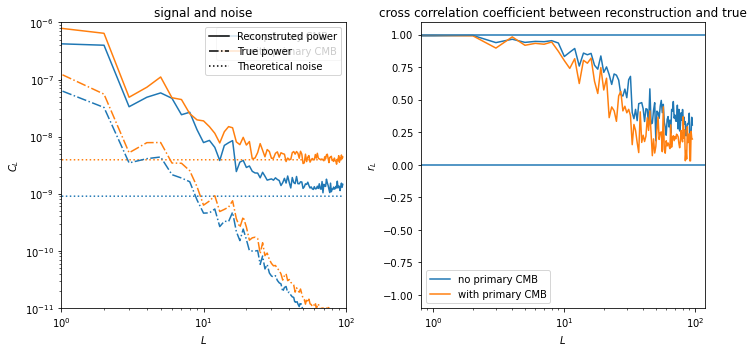

Bin 1


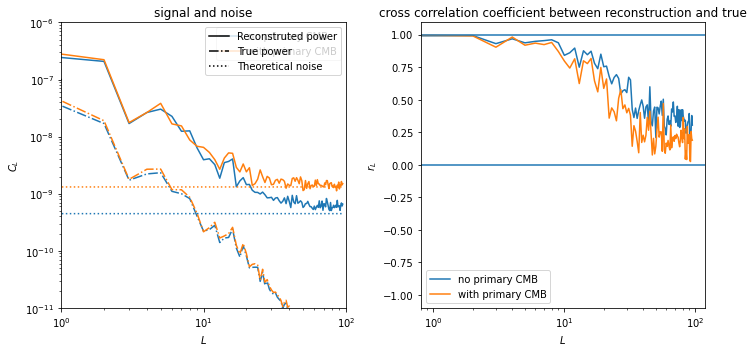

Bin 2


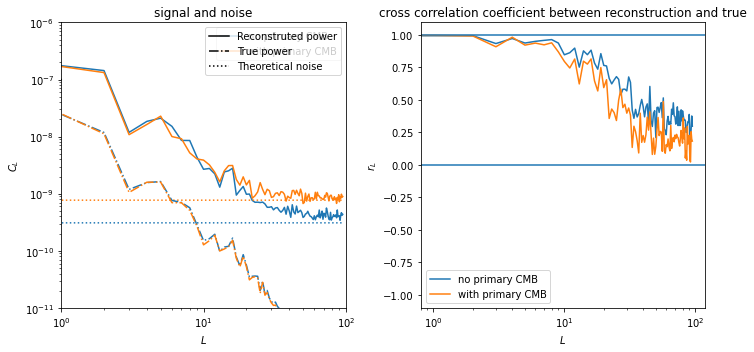

Bin 3


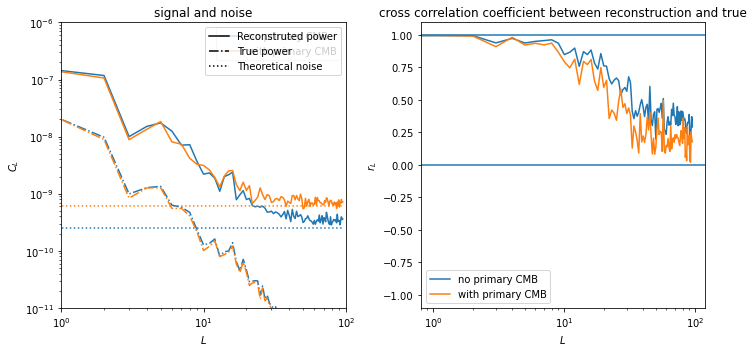

Bin 4


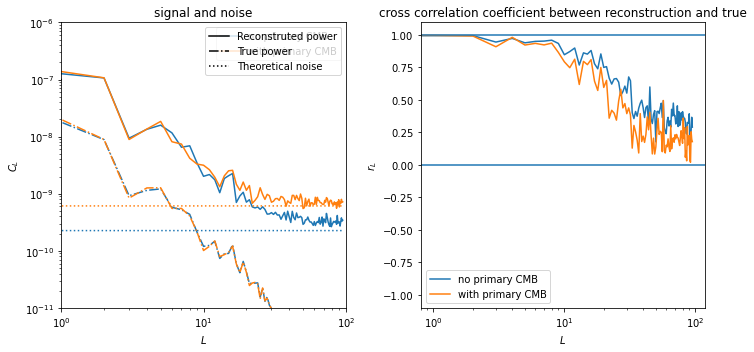

Bin 5


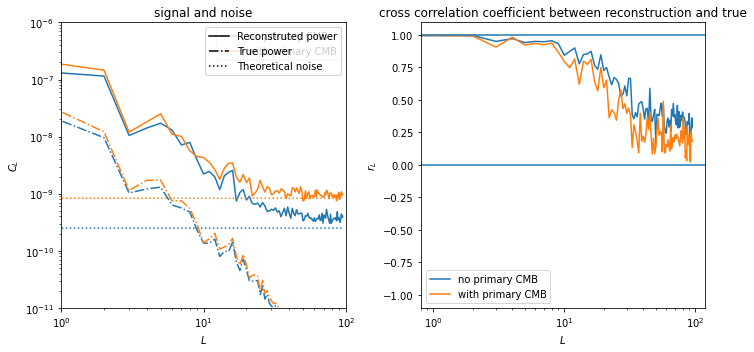

Bin 6


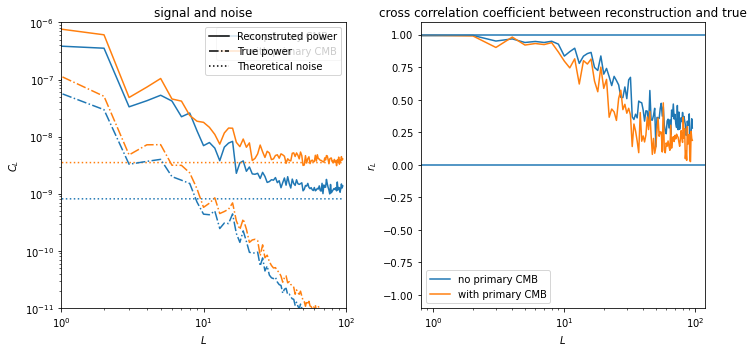

Bin 7


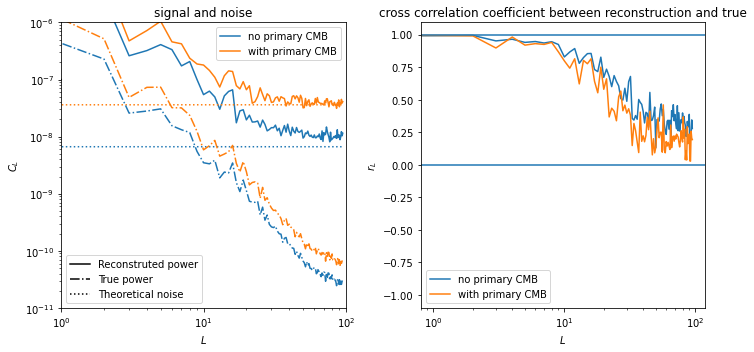

In [130]:
for x in range(0,NBIN):
    print("Bin "+str(x))
    plt.figure(figsize=(10,5))
    ax = plt.subplot(121)
    l1,=plt.loglog(hp.anafast(qe[x]/1e6),label='no primary CMB')
    l2,=plt.loglog(hp.anafast(qe_withcmb[x]/1e6),label='with primary CMB')

    plt.plot(noise[x,x]/1e6**2,color=l1.get_color(),ls=':')
    plt.plot(noise_withcmb[x,x]/1e6**2,color=l2.get_color(),ls=':')

    plt.loglog(hp.anafast(vtrue_Rot[x]),color=l1.get_color(),ls='-.') 
    plt.loglog(hp.anafast(vtrue_Rot_cmb[x]),color=l2.get_color(),ls='-.') 


    

    plt.title("signal and noise")
    plt.xlabel(r'$L$')
    plt.ylabel(r'$C_L$')
    
    plt.ylim(1e-11,1e-6)

    leg1 = plt.legend()
    
    l1,=plt.plot([0,1e-7],color='black')
    l2,=plt.plot([0,1e-7],color='black',ls='-.')

    l3,=plt.plot([0,1e-7],color='black',ls=':')
    leg2 = plt.legend([l1,l2,l3],['Reconstruted power','True power','Theoretical noise'])
    ax.add_artist(leg1)
    
    plt.xlim(1,100)
    
    plt.subplot(122)

    crosscor = hp.anafast(qe[x],vtrue_Rot[x])/np.sqrt(hp.anafast(qe[x])*hp.anafast(vtrue_Rot[x]))

    crosscor_cmb = hp.anafast(qe_withcmb[x],vtrue_Rot_cmb[x])/np.sqrt(hp.anafast(qe_withcmb[x])*hp.anafast(vtrue_Rot_cmb[x]))
    plt.plot(-crosscor,label='no primary CMB')
    plt.plot(-crosscor_cmb,label='with primary CMB')

    plt.xscale("log")
    plt.xlabel(r"$L$")
    plt.ylabel(r"$r_L$")
    plt.axhline(1)
    plt.axhline(0)
    plt.title("cross correlation coefficient between reconstruction and true")
    plt.legend()
    plt.tight_layout()
    plt.show()

If everything is correct, C_ell(qe[x],qe[y]) should be equal to noise(x,y) so here I just check if this looks true; it doesn't look bad

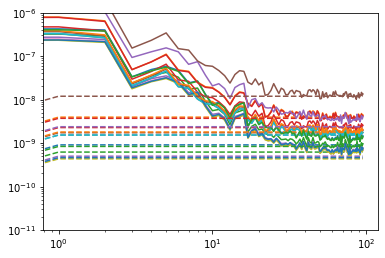

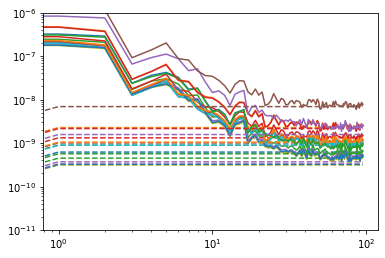

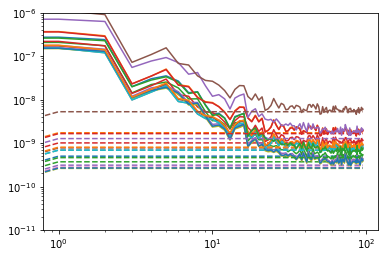

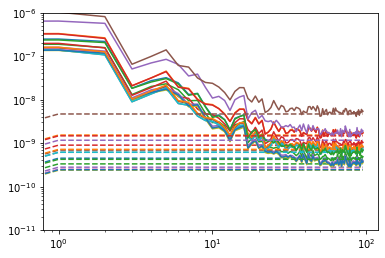

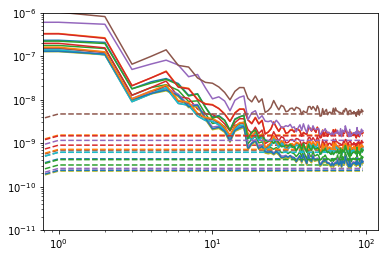

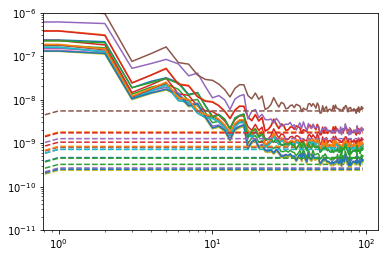

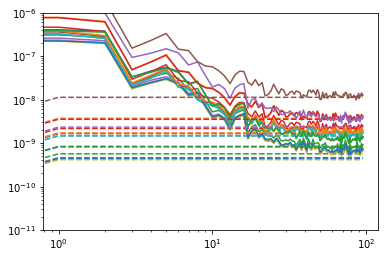

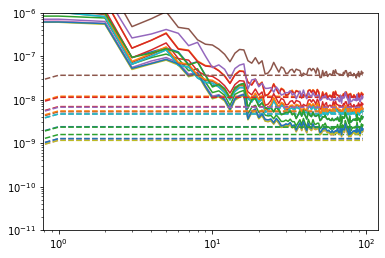

In [131]:
for x in range(0,NBIN):
    for y in range(0,NBIN):
        l1,=plt.loglog(hp.anafast(qe[x]/1e6,qe[y]/1e6),label='no primary CMB')
        l2,=plt.loglog(hp.anafast(qe_withcmb[x]/1e6,qe_withcmb[y]/1e6),label='with primary CMB')

        plt.plot(noise[x,y]/1e6**2,color=l1.get_color(),ls='--')
        plt.plot(noise_withcmb[x,y]/1e6**2,color=l2.get_color(),ls='--')

      #  plt.loglog(hp.anafast(vtrue_Rot[x],vtrue_Rot[y]),label='True (no CMB)',color='black') 
      #  plt.loglog(hp.anafast(vtrue_Rot_cmb[x],vtrue_Rot_cmb[y]),label='True (with CMB)',color='red') 
    plt.ylim(1e-11,1e-6)
    plt.show()

### what are we reconstructing?

Recall that we are comparing with a rotated velocity, V_rot = R V_{true}

To get insight into what we are reconstructing, we can plot the elements of R 

Think of this as $v_i = \sum_j R_{ij} c_j$; I plot I am plotting R_{Xj} for X={0,...,N}

if $C_\ell(taud, g)_{\alpha,\beta}$  is diagonal in redshift bin-space (ie, $\alpha-\beta$)these should just be Kronecker deltas, ie no rotation!!

also note, each estimator (labeled by X) might have a different redshift distribution



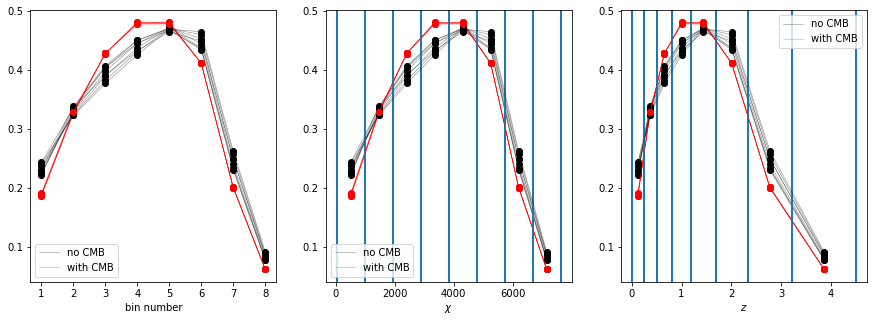

In [135]:
plt.figure(figsize=(15,5))
for x in range(0,NBIN):
    for y in range(0,3):
        plt.subplot(1,3,y+1)
        if y==0:
            xaxis = np.arange(1,NBIN+1)
            plt.xlabel('bin number')
        elif y ==1:
            xaxis = (EST.zb.zbins_chi[1:]+ EST.zb.zbins_chi[:-1])/2
            plt.xlabel(r'$\chi$')
            for chi in EST.zb.zbins_chi:
                plt.axvline(chi)
        elif y==2:
            xaxis = (EST.zb.zbins_z[1:]+ EST.zb.zbins_z[:-1])/2
            plt.xlabel(r'$z$')


            for z in EST.zb.zbins_z:
                plt.axvline(z)

        plt.plot(xaxis,R[x]/np.linalg.norm(R[x]),'black',alpha=0.5,lw=0.5,label='no CMB')
        plt.plot(xaxis,R[x]/np.linalg.norm(R[x]),'o',color='black',)


        plt.plot(xaxis,R_withCMB[x]/np.linalg.norm(R_withCMB[x]),'red',alpha=0.5,lw=0.5,label='with CMB')
        plt.plot(xaxis,R_withCMB[x]/np.linalg.norm(R_withCMB[x]),'o',color='red')
        if x==0:
            plt.legend()

plt.show()

Because the redshift distributions for each X are all so similar, I don't bother to label them. Note that "with-CMB" ones are all so similar that you cannot even see the different lines.

Also, I have plotted against bin number but also against mean redshfit and mean chi for the bins (for the chi- and z- plots I also indicated the boundaries of the bins

In general, we see something that could be similar to the CIB redshift distribtion, peaking at z between 1 and 2 :)

## Principle component decomposition

### We have created Nbins highly correlated estimators of a very similar rotated velocity field! We can do a change of basis to find the principle components.

In [138]:
def diagonalize(matrix):
    
    eigenvalues,eigenvectors = np.linalg.eig(matrix)
    transformed_matrix = np.matmul(np.matmul(np.transpose(eigenvectors),matrix),(eigenvectors))
    return np.transpose(eigenvectors), transformed_matrix
def to_identity(matrix):
    eigenvalues,eigenvectors = np.linalg.eig(matrix)
    transformation = 1/np.sqrt(matrix.diagonal())*np.identity(NBIN)
    transformed_matrix  = np.matmul(np.matmul(transformation,matrix),np.transpose(transformation))
    return transformation,transformed_matrix

def diagonalize_signalandnoise(signal,noise):
    first_transformation,noise = diagonalize(noise.copy())
    signal = np.matmul(np.matmul(first_transformation,signal),np.transpose(first_transformation))
    second_transformation,noise = to_identity(noise.copy())
    signal = np.matmul(np.matmul(second_transformation,signal),np.transpose(second_transformation))
    third_transformation,signal = diagonalize(signal.copy())
    return np.matmul(third_transformation,np.matmul(second_transformation,first_transformation)),signal.copy()

##### To do this PC decomposition, we will need the true signal (this should be calculated theoretically; ReCCO has this ability by calculating the velocity power spectra with python spectra.py -t1 vr -t2 vr -lmax 6144 but for now we just take the measured signal from the simulations

Also note we need the true *rotated* signal, to account for estimator bias This will be differnet for with-CMB and without-CMB (we could also do a PC decomposition on the true unrotated signal but first we would have to debias the estimators by going from qe to R^{-1} QE and noise to R^{-1} . noise. R^{-1}^{T}

In [143]:
signal = np.zeros((NBIN,NBIN,3*nsideout))
for x in range(0,NBIN):
    for y in range(0,NBIN):
        signal[x,y,1:] = hp.anafast(vtrue_Rot[x]*1e6,vtrue_Rot[y]*1e6)[1:]

signal_withCMB = np.zeros((NBIN,NBIN,3*nsideout))
for x in range(0,NBIN):
    for y in range(0,NBIN):
        signal_withCMB[x,y,1:] = hp.anafast(vtrue_Rot_cmb[x]*1e6,vtrue_Rot_cmb[y]*1e6)[1:]




### calcualte: the total signal to noise of each mode s2n:

In [145]:
s2n = np.zeros(signal.shape)
transformation = np.zeros((NBIN,NBIN,signal.shape[-1]))
for ellind in np.arange(1,96):
    transformation[:,:,ellind],s2n[:,:,ellind] = diagonalize_signalandnoise(signal[:,:,ellind].copy(),noise[:,:,ellind].copy())
    
s2n_withcmb = np.zeros(signal.shape)
transformation_withcmb = np.zeros((NBIN,NBIN,signal.shape[-1]))
for ellind in np.arange(1,96):
    transformation_withcmb[:,:,ellind],s2n_withcmb[:,:,ellind] = diagonalize_signalandnoise(signal_withCMB[:,:,ellind].copy(),noise_withcmb[:,:,ellind].copy())

    
    

/tmp/ipykernel_1053535/1392045735.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation[:,:,ellind],s2n[:,:,ellind] = diagonalize_signalandnoise(signal[:,:,ellind].copy(),noise[:,:,ellind].copy())
/tmp/ipykernel_1053535/1392045735.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_withcmb[:,:,ellind],s2n_withcmb[:,:,ellind] = diagonalize_signalandnoise(signal_withCMB[:,:,ellind].copy(),noise_withcmb[:,:,ellind].copy())


#### For a reconstruction with 1 tracer, only one mode should be well reconstructed. let's plot the signal to noise per mode:

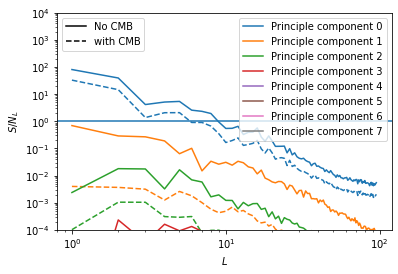

In [148]:
figure=plt.figure()
ax = plt.subplot(111)

nocmb,=plt.plot(1,1,color='black',ls='-')

withcmb,=plt.plot(1,1,color='black',ls='--')

leg2 = plt.legend([nocmb,withcmb],['No CMB','with CMB'],loc='upper left')
for x in range(0,NBIN):
    l1,=plt.plot(np.arange(1,96),s2n[x,x,1:],label='Principle component '+str(x))
    plt.plot(np.arange(1,96),s2n_withcmb[x,x,1:],color=l1.get_color(),ls='--')
leg1 = plt.legend()

plt.yscale("log")
plt.axhline(1)
plt.xscale("log")
plt.xlabel(r"$L$")
plt.ylabel(r"$S/N_L$")
plt.ylim(1e-4,1e4)
ax.add_artist(leg2)


## Let's see what redshifts our signal to noise is coming from!

### "total trans" is the total transformation we must do on the unbiased velocity field to get the principle components; it is simply our PC transformation post-multiplied by our rotation matrix R

In [150]:
total_trans = np.zeros(transformation.shape)
for ellind in range(0,transformation.shape[-1]):
    total_trans[:,:,ellind] = np.matmul(transformation[:,:,3],R)
total_trans_withCMB = np.zeros(transformation.shape)
for ellind in range(0,transformation.shape[-1]):
    total_trans_withCMB[:,:,ellind] = np.matmul(transformation_withcmb[:,:,3],R_withCMB)

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

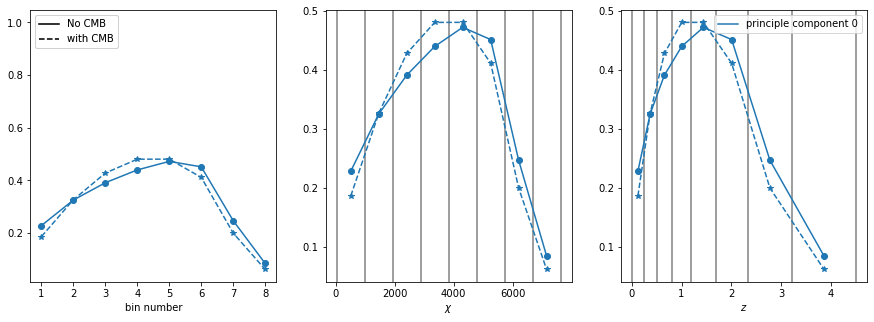

In [165]:
figure=plt.figure(figsize=(15,5))
ax = plt.subplot(131)

nocmb,=plt.plot(1,1,color='black',ls='-')

withcmb,=plt.plot(1,1,color='black',ls='--')

leg2 = plt.legend([nocmb,withcmb],['No CMB','with CMB'],loc='upper left')

PC = 0 #we are interested in the first principle component; change this if you want a higher PC

for x in range(PC,PC+1):
    for y in range(0,3):
        plt.subplot(1,3,y+1)
        if y==0:
            xaxis = np.arange(1,NBIN+1)
            plt.xlabel('bin number')
        elif y ==1:
            xaxis = (EST.zb.zbins_chi[1:]+ EST.zb.zbins_chi[:-1])/2
            plt.xlabel(r'$\chi$')
            for chi in EST.zb.zbins_chi:
                plt.axvline(chi,color='gray')
        elif y==2:
            xaxis = (EST.zb.zbins_z[1:]+ EST.zb.zbins_z[:-1])/2
            plt.xlabel(r'$z$')


            for z in EST.zb.zbins_z:
                plt.axvline(z,color='gray')
        l1,=plt.plot(xaxis,np.abs(total_trans[x,:,3]/np.linalg.norm(total_trans[x,:,3])),alpha=1,label = 'principle component '+str(x))
        plt.plot(xaxis,np.abs(total_trans[x,:,3]/np.linalg.norm(total_trans[x,:,3])),'o',color=l1.get_color(),alpha=1)


        plt.plot(xaxis,np.abs(total_trans_withCMB[x,:,3]/np.linalg.norm(total_trans_withCMB[x,:,3])),color=l1.get_color(),alpha=1,ls='--')
        plt.plot(xaxis,np.abs(total_trans_withCMB[x,:,3]/np.linalg.norm(total_trans_withCMB[x,:,3])),'*',color=l1.get_color(),alpha=1)
    #plt.axhline(1)
l2=plt.legend()
ax =  plt.subplot(1,3,1)
ax.add_artist(leg2)
ax2 =  plt.subplot(1,3,2)
ax2.add_artist(leg2)

